# MNIST, distance euclidienne et similarité pixel
Dans ce document, nous allons exécuter plusieurs algorithmes d'apprentissage machine.
Ceci sont les importations que nous aurons besoin pour le projet. Nous utiliserons SKlearn tel que indiqué par le professeur.

In [1]:
import matplotlib.pyplot as plt
import sparse as sparse
from sklearn.metrics import accuracy_score
from sklearn import metrics


#classification
from sklearn.neighbors import KNeighborsClassifier #k-plus proches voisins
from sklearn_extra.cluster import KMedoids
import numpy as np
import pandas as pd
from time import time

#Partitionnement
from sklearn.cluster import AgglomerativeClustering #Regroupement hiérarchique (Partitionnement binaire)
#from pyclustering.cluster.kmedoids import kmedoids
import kmedoids

#réduction de dimensionnalité
from sklearn.decomposition import KernelPCA #ce n'est pas PCoA mais on peut l'utiliser pour que le résultat soit le même
from sklearn.manifold import Isomap

Pour commencer le projet, nous allons devoir importer MNIST et standardiser les données, car certains des algorithmes que nous devons implémenter ne fonctionnent pas très bien avec des données non standardisées. Voici les algorithmes :

● k-medoïde
● Partition binaire (Regroupement hiérarchique)
● PCoA (c'est un cas particulier de MDS)
● Isomap
● KNN (k-plus proches voisins)

Nous allons aussi préparer les jeux de données pour la similarité de pixel dans le bloc qui suit. La mesure de similarité que nous allons utiliser pour MNIST sera la somme des pixels dans l'image. Ensuite, nous ferons la différence de cette somme avec les autres images pour avoir le niveau de similarité. Plus le chiffre sera petit, plus les images se ressembleront, et donc elles auront plus de chance d'appartenir à la même classe. La logique ici est que les images qui font partis de la même classe devrait avoir des formes similaires, ce qui implique ainsi que le nombre de pixels allumés dans l'écran sera environ le même. Un des problèmes qui saute aux yeux dès le début avec cette similarité serait l'exemple des 6 et des 9, qui ont une forme très semblable et nous pouvons présumer que le nombre de pixels qui sont allumés doivent se ressembler fortement. Cependant, nous avons confiance que la similarité de pixels sera robuste pour les autres chiffres. Nous avons aussi décidé de ne pas binariser l'image, car nous avions l'impression que nous perdions trop de précision dans les sommes d'images et que cela rendrait nos images indistinguables.
### Avertissement
Les matrices de similarité et euclidiennes prennent beaucoup de RAM à calculer. Les performances des algorithmes peuvent varier selon vos spécifications machine.

In [2]:
from sklearn.preprocessing import StandardScaler, normalize, binarize
from sklearn.decomposition import PCA
# https://notebook.community/francesco-mannella/neunet-basics/course/mnist
from mnist import MNIST

# init with the 'data' dir
mndata = MNIST('.\data')

# Load data
(train_X, train_y) = mndata.load_training()
data_train = pd.DataFrame(train_X)
(test_X, test_y) = mndata.load_testing()
data_test = pd.DataFrame(test_X)

print('X_train: ' + str(np.shape(train_X)))
print('Y_train: ' + str(np.shape(train_y)))
print('X_test:  '  + str(np.shape(test_X)))
print('Y_test:  '  + str(np.shape(test_y)))

# Binarization of data
# Threshold of 100 for the pixels. If they are not lit enough, they are not counted.
#X_binarized_train = binarize(train_X, threshold=100, copy=True)
#X_binarized_test = binarize(train_X, threshold=100, copy=True)

# Pixel similarity transformation
X_pixel_train = np.zeros(shape=(len(train_X), 1), dtype='int')
X_pixel_test = np.zeros(shape=(len(test_X), 1), dtype='int')

# Summation of all the pixels inside the training set
for i in range(len(train_X)):
    #X_pixel_train[i] = np.sum(X_binarized_train[i], axis=0)
    X_pixel_train[i] = np.sum(train_X[i], axis=0)

# Summation of all the pixels inside the testing set
for i in range(len(test_X)):
    #X_pixel_test[i] = np.sum(X_binarized_test[i], axis=0)
    X_pixel_test[i] = np.sum(test_X[i], axis=0)

# Standardizing the data (preprocessing)
scaler = StandardScaler()

X_std_train = scaler.fit_transform(train_X)
X_std_pixel_train = scaler.fit_transform(X_pixel_train)

X_std_test = scaler.fit_transform(test_X)
X_std_pixel_test = scaler.fit_transform(X_pixel_test)

# Reduction of dimensionality
# This step is necessary for some algorithms i.e. k-medoids is just like kmeans and the algorithm doesn't scale very well to high dimensions
pca = PCA(n_components = 2)
# Reduced training data set
X_principal = pca.fit_transform(X_std_train)
cutoff = np.median(X_principal)

# The number of pixels per side of all images
img_side = 28

# Each input is a raw vector.
# The number of units of the network
# corresponds to the number of input elements
n_mnist_pixels = img_side*img_side

X_train: (60000, 784)
Y_train: (60000,)
X_test:  (10000, 784)
Y_test:  (10000,)


Ceci est la méthode qui sera utilisée pour générer la matrix de similarité

In [3]:
def pixel_similarity(x, y):
    # return the pixel similarity matrix
    return np.abs(x-y).sum(axis=2)


def get_pixel_similarity_matrix(X, Y=None):
    Y = X if Y is None else Y
    return pixel_similarity(X[:,None], Y[None,:])

Cette partie ici ne sert qu'à tester sur votre machine combien de temps de calcul la machine prendra en moyenne pour calculer la matrix de similarité. Nous avons inclus en commentaires le temps que cela a pris sur notre machine.

In [ ]:
from time import time
start = time()
print(np.shape(get_pixel_similarity_matrix(X_std_pixel_train)))
print("Calculating the train pixel similarity matrix took: %.2f s" % (time() - start))
# Calculating the test pixel similarity matrix took: 271.51 s (5 minutes)
# Calculating the train pixel similarity matrix took: 704.23 s (12 minutes)

Ici on vérifie que le dataset à bien téléchargé et nous imprimons quelques images pour s'assurer que tout est en ordre.

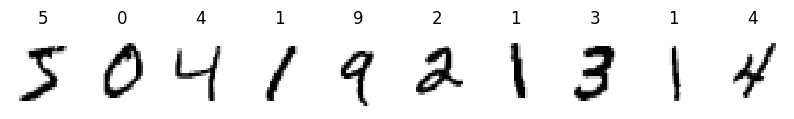

In [4]:
%matplotlib inline
from pylab import *

# Define the number of samples to take
num_samples = 10

# create a figure where we will store all samples
figure(figsize=(10,1))

# Iterate over samples indices
for sample in range(num_samples) :

    # The image corresponding to the 'sample' index
    img = train_X[sample]

    # The label of the image
    label = train_y[sample]

    # The image is stored as a rolled vector,
    # we have to roll it back in a matrix
    aimg = array(img).reshape(img_side, img_side)

    # Open a subplot for each sample
    subplot(1, num_samples, sample+1)

    # The corresponding digit is the title of the plot
    title(label)

    # We use imshow to plot the matrix of pixels
    imshow(aimg, interpolation = 'none',
        aspect = 'auto', cmap = cm.binary)
    axis("off")

show()

# Algorithme de K-medoïde
## Distance Euclidienne
Nous allons commencer par faire l'algorithme de k-medoïde avec la distance euclidienne pour MNIST. Dans le bloc suivant, il y aura le même algorithme, mais avec la similarité de pixel.

In [ ]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html?fbclid=IwAR2CjekTcfhnp19Txryk2u5c2w2Zoa9O1kEBR710Bcg8kPNuCXQWj0-_zm8
# https://medium.com/@ali.soleymani.co/beyond-scikit-learn-is-it-time-to-retire-k-means-and-use-this-method-instead-b8eb9ca9079a
from sklearn.metrics import euclidean_distances
from sklearn import metrics
from time import time

start = time()
fp = kmedoids.fasterpam(euclidean_distances(X_principal), medoids=10, max_iter=100)

print("FasterPAM with euclidean distance took: %.2f ms" % ((time() - start)*1000))
print("Loss with FasterPAM:", fp.loss)
homo = metrics.homogeneity_score(labels_true=train_y, labels_pred=fp.labels)
compl = metrics.completeness_score(labels_true=train_y, labels_pred=fp.labels)
v_meas = metrics.v_measure_score(labels_true=train_y, labels_pred=fp.labels)
ARI = metrics.adjusted_rand_score(labels_true=train_y, labels_pred=fp.labels)
AMI = metrics.adjusted_mutual_info_score(labels_true=train_y, labels_pred=fp.labels)
silhouette = metrics.silhouette_score(X_principal,train_y, metric='euclidean', sample_size=np.shape(X_principal)[0])

print(82 * "_")
print("\ttime\thomo\tcompl\tv_meas\tARI\tAMI\tsilhouette")
print(f"{(time() - start)*1000} ms {homo} {compl} {v_meas} {ARI} {AMI} {silhouette}")
print(82 * "_")

# Commented this section because it takes way too much time, for very similar results, partly due to the deterministic nature of PCA
# start = time()
# pam = kmedoids.pam(diss, medoids=10, max_iter=100)
# homo = metrics.homogeneity_score(labels_true=train_y, labels_pred=pam.labels)
# compl = metrics.completeness_score(labels_true=train_y, labels_pred=pam.labels)
# v_meas = metrics.v_measure_score(labels_true=train_y, labels_pred=pam.labels)
# ARI = metrics.adjusted_rand_score(labels_true=train_y, labels_pred=pam.labels)
# AMI = metrics.adjusted_mutual_info_score(labels_true=train_y, labels_pred=pam.labels)
# silhouette = metrics.silhouette_score(X_principal,train_y, metric='euclidean', sample_size=np.shape(X_principal)[0])
# print("Loss with PAM:", pam.loss)
# print("PAM took: %.2f ms" % ((time() - start)*1000))
# print(82 * "_")
# print("\ttime\thomo\tcompl\tv_meas\tARI\tAMI\tsilhouette")
# print(f"{(time() - start)*1000} ms {homo} {compl} {v_meas} {ARI} {AMI} {silhouette}")
# print(82 * "_")

## Similarité de Pixel

In [ ]:
from sklearn import metrics
from time import time

start = time()
fp = kmedoids.fasterpam(get_pixel_similarity_matrix(X_std_pixel_train), medoids=10, max_iter=100)

print("FasterPAM with pixel similarity took: %.2f ms" % ((time() - start)*1000))
print("Loss with FasterPAM:", fp.loss)
homo = metrics.homogeneity_score(labels_true=train_y, labels_pred=fp.labels)
compl = metrics.completeness_score(labels_true=train_y, labels_pred=fp.labels)
v_meas = metrics.v_measure_score(labels_true=train_y, labels_pred=fp.labels)
ARI = metrics.adjusted_rand_score(labels_true=train_y, labels_pred=fp.labels)
AMI = metrics.adjusted_mutual_info_score(labels_true=train_y, labels_pred=fp.labels)
silhouette = metrics.silhouette_score(get_pixel_similarity_matrix(X_std_pixel_train),train_y, metric='precomputed', sample_size=np.shape(X_std_pixel_train)[0])

print(82 * "_")
print("\ttime\thomo\tcompl\tv_meas\tARI\tAMI\tsilhouette")
print(f"{(time() - start)*1000} ms {homo} {compl} {v_meas} {ARI} {AMI} {silhouette}")
print(82 * "_")

## Conclusion
Voici les métriques collectées pour la distance euclidienne :
__________________________________________________________________________________
	time(s) homo    compl   v_meas  ARI     AMI     silhouette
    620.091 0.2175  0.2234  0.2204  0.1427  0.2202  -0.0670
__________________________________________________________________________________

Et voici les métriques collectées pour la similarité de pixel :
__________________________________________________________________________________
	time(s) homo    compl   v_meas  ARI     AMI     silhouette
	1407.364 0.1017 0.1037  0.1027  0.0527  0.1024  -0.1337
__________________________________________________________________________________

Il est assez clair ici avec ces métriques, que la similarité de pixel est beaucoup plus lente, environ 2x plus lente et les groupes sont beaucoup moins homogènes. En général, les métriques sont beaucoup moins bonnes pour la similarité, on peut donc en conclure que ce n'est pas une bonne métrique pour l'algorithme des K-medoïde.

# Partionnement Binaire
## Distance Euclidienne
Ici nous ferons la partition binaire avec la distance euclidienne pour MNIST. Pour la distance euclidienne et la similarité, nous avons assumé qu'il y avait 10 groupes, car nous savons qu'il y a 10 classes d'images pour MNIST.

In [ ]:
# Prédictions en faisant la moyenne
def agglomerative_clustering_predict(agglomerative_clustering, X):
    average = list()
    ith_clusters = list()
    for i in range(agglomerative_clustering.n_clusters):
        # On fouille dans les train_X pour tous les labels i
        for j in range(len(agglomerative_clustering.labels_)):
            if agglomerative_clustering.labels_[j]==i:
                ith_clusters.append(X.iloc[j])
        average.append(np.array(ith_clusters).mean(axis=1))
    # np.stack makes this error: all input arrays must have the same shape
    return np.argmin(np.stack(average), axis=0)

In [12]:
from time import time
from sklearn.metrics.cluster import v_measure_score


# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# https://www.projectpro.io/recipes/do-agglomerative-clustering-in-python
# https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

# pca = PCA(n_components = 2)
# # Training data set
# X_principal = pca.fit_transform(X_std_train)
# X_principal = pd.DataFrame(X_principal)
# print(X_principal)
#X_principal.columns = ['P1', 'P2']

# # Testing data set
# X_secondary = pca.fit_transform(X_normalized_test)
# X_secondary = pd.DataFrame(X_secondary)
# X_secondary.columns = ['P1', 'P2']

# Dendogram requires normalized data, which is bad for mnist
# plt.figure(figsize =(8, 8))
# plt.title('Visualising the data')
# Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))


start = time()
ac10 = AgglomerativeClustering(n_clusters = 10, affinity='euclidean')
labels = pd.DataFrame(ac10.fit_predict(X_std_train))

#vscore = v_measure_score(labels_true=train_y, labels_pred=labels.iloc[:, 0])

#print(f"V-measure score for agglomerative clustering with 10 clusters: {vscore}")

print("Agglomerative clustering with euclidean distance took: %.2f s" % (time() - start))
print(f"V-measure score for agglomerative clustering with 10 clusters: {v_measure_score(labels_true=train_y, labels_pred=labels.iloc[:, 0])}")

# homo = metrics.homogeneity_score(labels_true=train_y, labels_pred=labels.iloc[:, 0])
# compl = metrics.completeness_score(labels_true=train_y, labels_pred=labels.iloc[:, 0])
# v_meas = v_measure_score(labels_true=train_y, labels_pred=labels.iloc[:, 0])
# ARI = metrics.adjusted_rand_score(labels_true=train_y, labels_pred=labels.iloc[:, 0])
# AMI = metrics.adjusted_mutual_info_score(labels_true=train_y, labels_pred=labels.iloc[:, 0])
# silhouette = metrics.silhouette_score(X_std_train,train_y, metric='euclidean', sample_size=np.shape(X_std_train)[0])


# V-measure score for agglomerative clustering with 10 clusters: 0.5844426454187285
# Agglomerative clustering with euclidean distance took: 801.10 s


Agglomerative clustering with euclidean distance took: 790.28 s
V-measure score for agglomerative clustering with 10 clusters: 0.5844426454187285


## Similarité de Pixel

In [ ]:
from time import time
from sklearn.metrics.cluster import v_measure_score

start = time()
ac_pixel = AgglomerativeClustering(n_clusters = 10, affinity='precomputed', linkage='average')
labels = ac_pixel.fit_predict(get_pixel_similarity_matrix(X_std_pixel_train))
print(f"V-measure score for agglomerative clustering with 10 clusters: {v_measure_score(labels_true=train_y, labels_pred=labels)}")
print("Agglomerative clustering with pixel similarity took: %.2f s" % (time() - start))
# Agglomerative clustering with pixel similarity took: 12135.04 s (202.25 minutes / 3.37 hours)
# V-measure score for agglomerative clustering with 10 clusters: 0.1076184112661532

## Conclusion
Puisque nous avons accès aux étiquettes pour les données, nous pouvons utiliser le v_measure_score pour évaluer la précision de l'algorithme.
Voici les résultats pour la distance euclidienne :
__Agglomerative clustering with euclidean distance took: 801.10 s__
__V-measure score for agglomerative clustering with 10 clusters : 0.5844426454187285__

Et les résultats pour la similarité de Pixel :
__Agglomerative clustering with pixel similarity took: 12135.04 s (202.25 minutes / 3.37 hours)__
__V-measure score for agglomerative clustering with 10 clusters: 0.1076184112661532__

Le résultat est assez évident que la similarité de pixel n'est pas du tout capable de faire une séparation claire. C'est à peine meilleur que de tirer au hasard, ce qui à vrai dire, n'est pas utile. En termes de temps, l'algorithme avec la similarité prend plus de temps que celle avec la distance euclidienne. Pour l'algorithme de partionnement, la similarité est pire que la distance euclidienne en tout points. Peut-être que si notre similarité avait des distinctions remarquables entre les classes, cela serait plus facile de faire des classes qui sépare bien. Sûrement que la binarization serait bénéfique ici, car cela nous permettrait de faire une distinction plus prononcée des classes, parce qu'on réduirait aux pixels les plus significatifs seulement.

# PCoA
## Distance Euclidienne
Ici nous ferons le PCoA avec la distance euclidienne pour MNIST

PCoA training with euclidean distance took: 2405.75 s
PCoA testing with euclidean distance took: 389.59 s


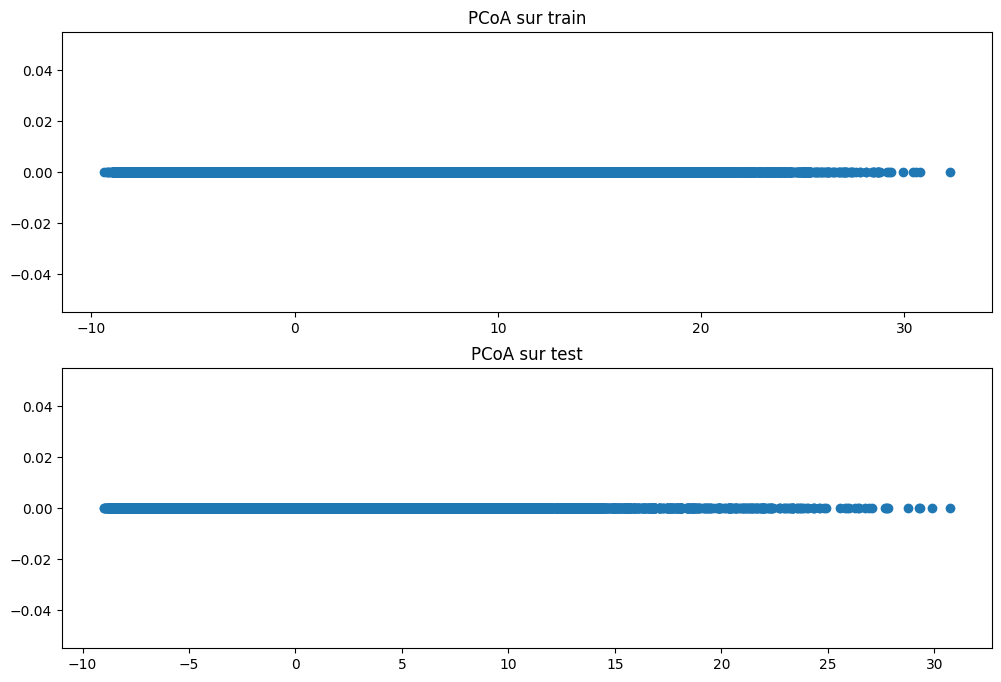

In [5]:
from time import time
from sklearn.metrics.pairwise import euclidean_distances

pcoa = KernelPCA(n_components=1, kernel='precomputed')

# Euclidean distance
start = time()
pcoa_euclidean_train = pcoa.fit_transform(-.5 * euclidean_distances(X_std_train) ** 2) #-.5*D**2 est crucial!!!
print("PCoA training with euclidean distance took: %.2f s" % (time() - start))
start = time()
pcoa_euclidean_test = pcoa.transform(-.5 * euclidean_distances(X_std_test, X_std_train) ** 2) #-.5*D**2 est crucial!!!
print("PCoA testing with euclidean distance took: %.2f s" % (time() - start))


# Euclidean distance
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
ax.set_title('PCoA sur train')
ax.scatter(pcoa_euclidean_train, np.zeros_like(pcoa_euclidean_train))

ax = fig.add_subplot(212)
ax.set_title('PCoA sur test')
ax.scatter(pcoa_euclidean_test, np.zeros_like(pcoa_euclidean_test))
#PCoA training with euclidean distance took: 5392.98 s

#PCoA training with euclidean distance took: 2405.75 s
#PCoA testing with euclidean distance took: 389.59 s


## Similarité de Pixel

In [ ]:
from time import time
pcoa = KernelPCA(n_components=1, kernel='precomputed')

# Pixel similarity
start = time()
pcoa_pixel_train = pcoa.fit_transform(-.5 * get_pixel_similarity_matrix(X_std_pixel_train) ** 2) #-.5*D**2 est crucial!!!
print("PCoA training with pixel similarity took: %.2f s" % (time() - start))
# PCoA training with pixel similarity took: 2932.46 s (49 minutes)

start = time()
pcoa_pixel_test = pcoa.transform(-.5 * get_pixel_similarity_matrix(X_std_pixel_test, X_std_pixel_train) ** 2) #-.5*D**2 est crucial!!!
print("PCoA testing with pixel similarity took: %.2f s" % (time() - start))
# PCoA training with pixel similarity took: 2535.06 s
# PCoA testing with pixel similarity took: 343.85 s

# Pixel similarity
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
ax.set_title('PCoA sur train')
ax.scatter(pcoa_pixel_train, np.zeros_like(pcoa_pixel_train))

ax = fig.add_subplot(212)
ax.set_title('PCoA sur test')
ax.scatter(pcoa_pixel_test, np.zeros_like(pcoa_pixel_test))

## Conclusion
Voici le résultat que nous avons obtenu pour la distance euclidienne :
![Euclidean Distance](Rapport/pcoa_euclidean.png)
__PCoA training with euclidean distance took: 2405.75 s__
__PCoA testing with euclidean distance took: 389.59 s__
__PCoA training with euclidean distance took: 5392.98 s__

Et voici le résultat de la similarité de pixel :
![Similarité Pixel](Rapport/pcoa_pixel_test.png)
__PCoA training with pixel similarity took: 2535.06 s__
__PCoA testing with pixel similarity took: 343.85 s__
__Total: 2,878.91 s (48 m)__

Puisque le PCoA est une transformation sur le plan à 1 dimension, et que la similarité de pixel est déjà réduite à une dimension, il aurait été logique que la transformation soit plus rapide. Cependant, cela a pris plus de temps, car le calcul de la similarité de pixel inclus une réduction de dimensionalité dans son calcul, ce qui prend plus de temps que la distance euclidienne. Finalement, la similarité de pixel est plus lente que la distance euclidienne pour PCoA.

# KNN
## Distance Euclidienne
Ici nous ferons le KNN avec la distance euclidienne pour MNIST. Après quelques tests aléatoire, nous avons trouvé que 5 voisins était un bon hyperparamètre pour l'algorithme de KNN dans le cas de MNIST.

In [11]:
from time import time
start = time()
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2, algorithm='auto')
knn.fit(train_X, train_y)
print("KNN training with euclidean distance took: %.2f s" % (time() - start))

start = time()
predictions = knn.predict(test_X)
print("KNN predictions with euclidean distance took: %.2f s" % (time() - start))

acc = accuracy_score(y_true=test_y, y_pred=predictions)
print(f"Accuracy for KNN algorithm with euclidean distance: {acc}")


KNN training with euclidean distance took: 3.93 s
KNN predictions with euclidean distance took: 12.42 s
Accuracy for KNN algorithm with euclidean distance: 0.9688


## Similarité de Pixel

In [ ]:
from time import time
start = time()
knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed', algorithm='auto')
knn.fit(get_pixel_similarity_matrix(X_std_pixel_train), train_y)
print("KNN training with pixel similarity took: %.2f s" % (time() - start))
# KNN training with pixel similarity took: 1261.69 s (21 minutes)

start = time()
predictions = knn.predict(get_pixel_similarity_matrix(X_std_pixel_test, X_std_pixel_train))
print("KNN predictions with pixel similarity took: %.2f s" % (time() - start))
acc = accuracy_score(y_true=test_y, y_pred=predictions)
print(f"Accuracy for KNN algorithm with pixel similarity: {acc}")
# KNN training with pixel similarity took: 4880.94 s
# KNN predictions with pixel similarity took: 726.11 s
# Accuracy for KNN algorithm with pixel similarity: 0.1904

## Conclusion
Voici nos métriques pour la distance euclidienne:
__KNN training with euclidean distance took: 3.93 s__
__KNN predictions with euclidean distance took: 12.42 s__
__Accuracy for KNN algorithm with euclidean distance: 0.9688__

Voici nos métriques pour la similarité de pixel:
__KNN training with pixel similarity took: 4880.94 s__
__KNN predictions with pixel similarity took: 726.11 s__
__Accuracy for KNN algorithm with pixel similarity: 0.1904__

Ici la différence est très flagrante. La précision de 19 % pour la similarité est très mauvais comparé à celui de la distance euclidienne de 96.8 %. La différence en temps est très énorme aussi. La similarité prend plusieurs minutes sur le jeu de données complet, tandis que la distance euclidienne retourne un résultat pratiquement instantanément. Nous croyons que la similarité est plus lente ici, car nous devons calculer la matrice des distances séparément et que SKlearn doit optimiser le calcul euclidien qui est intégré dans l'algorithme. Donc, la similarité de pixel est moins bonne que la distance euclidienne pour l'algorithme de KNN, mais pour le temps de calcul, nous croyons que ce n'est pas significatif pour cet algorithme.

# Isomap
## Distance Euclidienne
Ici nous ferons l’Isomap avec la distance euclidienne pour MNIST. Pour cet algorithme, nous avons aussi testé quelques valeurs pour le nombre de voisins et nous avions trouvé que 5 donnait un bon résultat.

Isomap took: 217.12 s


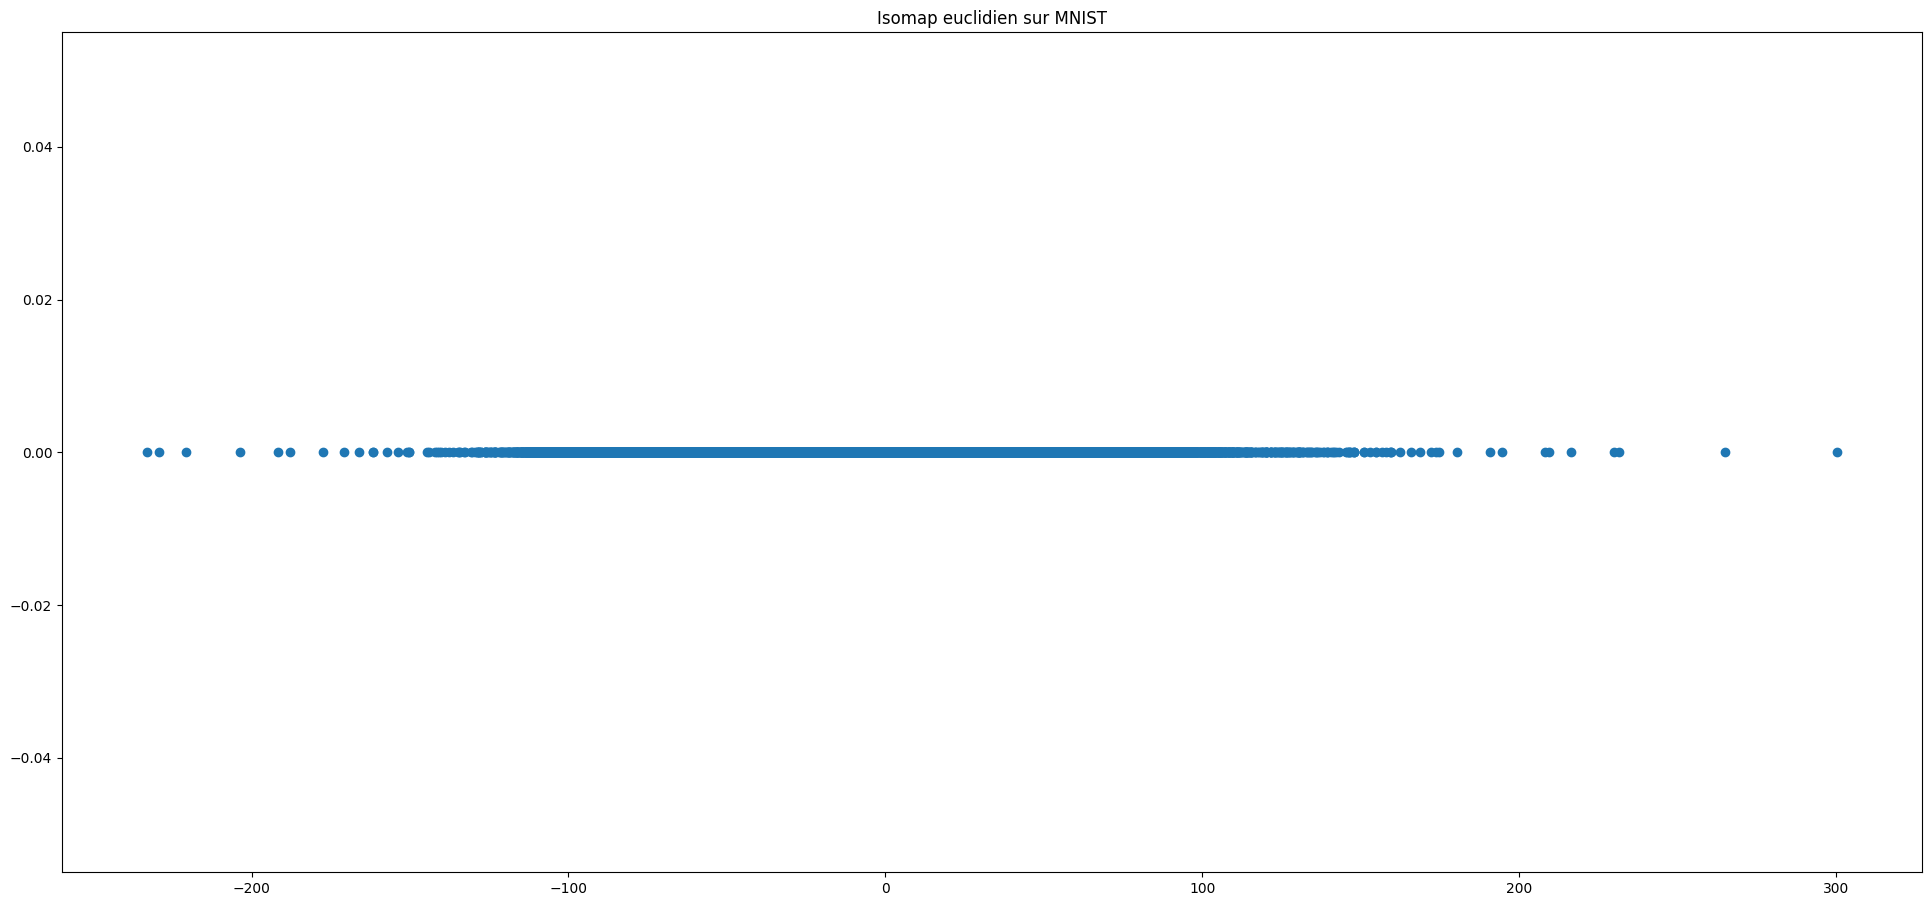

In [11]:
from time import time
isomap = Isomap(n_components=2, n_neighbors=5, metric='minkowski', p=2)

start = time()
X_transformed_isomap = isomap.fit_transform(X_std_train[0:20000, :])

print("Isomap took: %.2f s" % (time() - start))

fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(211)
ax.set_title('Isomap euclidien sur MNIST')
ax.scatter(X_transformed_isomap, np.zeros_like(X_transformed_isomap))

# Isomap took: 217.12 s


# Isomap_5n took: 6431123.26 ms (6,431.12326 s) (107.19 m) (1.79 h)
# UserWarning: The number of connected components of the neighbors graph is 37 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
# self._fit_transform(X)

## Similarité de Pixel

Isomap took: -133.88 s


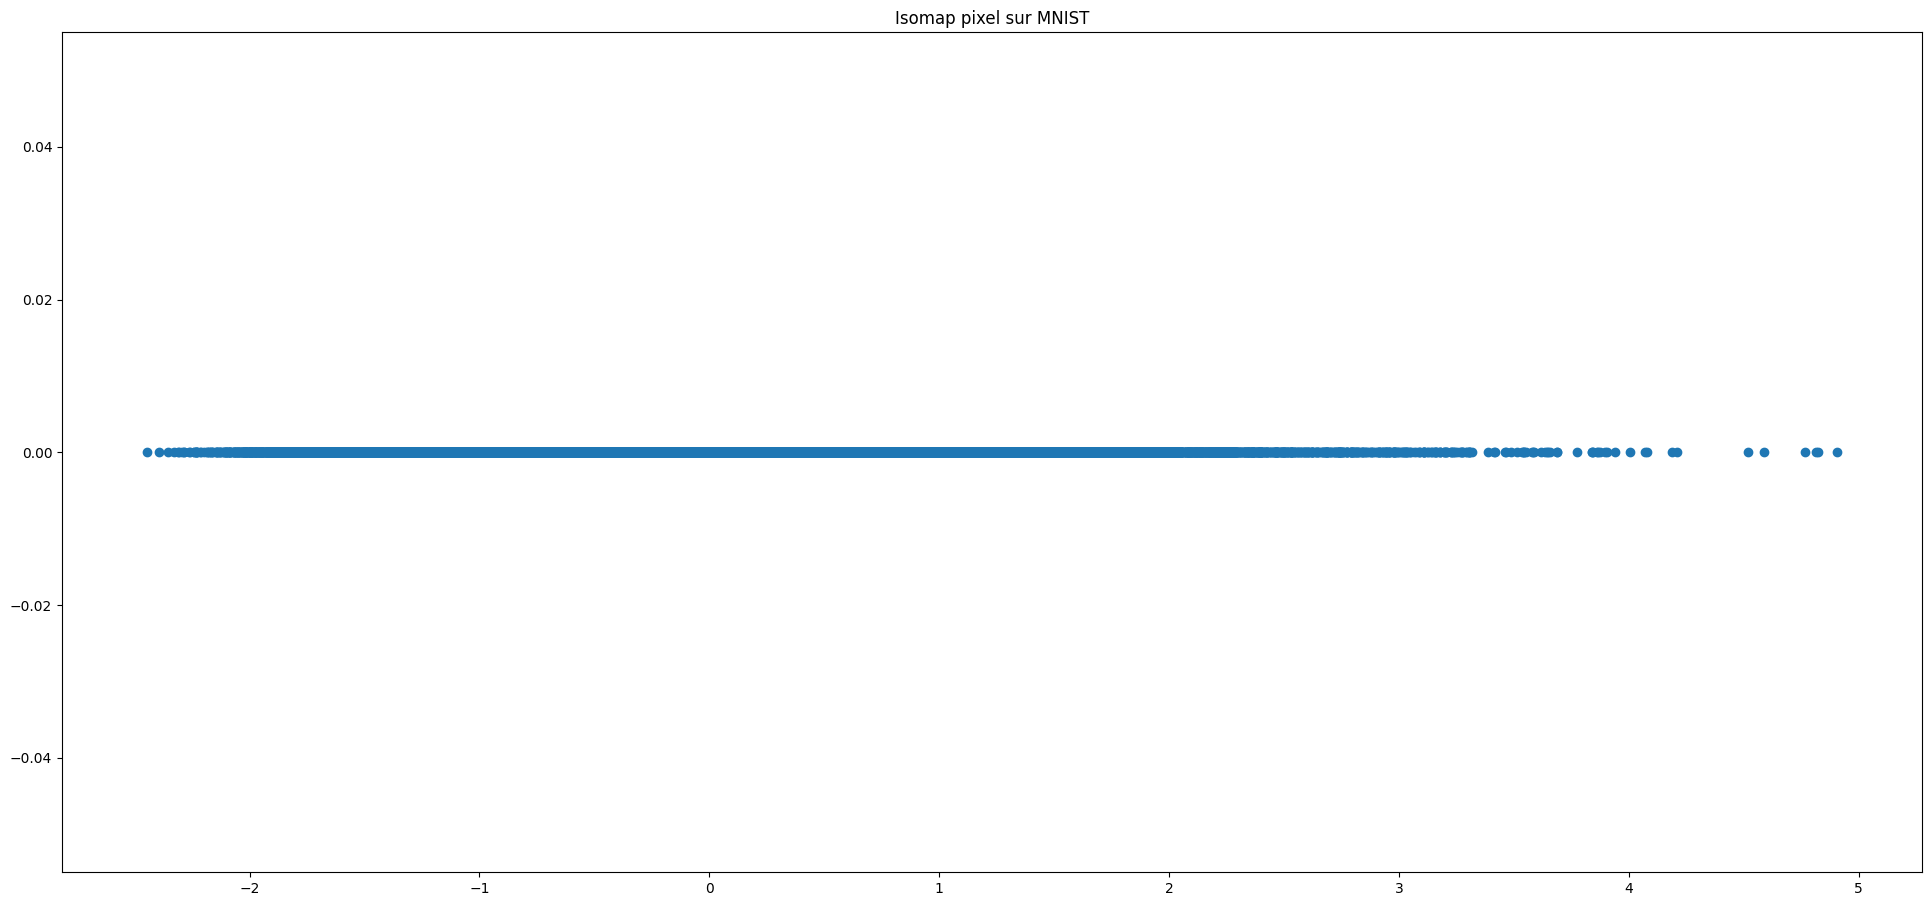

In [10]:
from time import time
isomap = Isomap(n_components=1, n_neighbors=12, metric='precomputed')
start = time()
X_transformed_isomap = isomap.fit_transform(get_pixel_similarity_matrix(X_std_pixel_train[0:20000, :]))

print("Isomap took: %.2f s" % (time() - start))

fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(211)
ax.set_title('Isomap pixel sur MNIST')
ax.scatter(X_transformed_isomap, np.zeros_like(X_transformed_isomap))
#Isomap took: 133.88 s


#D:\School Books\Session 5\IFT 3700\IFT-3700_TPs\Devoir 1\Devoir1\lib\site-packages\sklearn\manifold\_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 14 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
#   self._fit_transform(X)
# D:\School Books\Session 5\IFT 3700\IFT-3700_TPs\Devoir 1\Devoir1\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
#   self._set_intXint(row, col, x.flat[0])
# MemoryError: Unable to allocate 26.8 GiB for an array with shape (60000, 60000) and data type float64

## Conclusion

Voici nos résultats pour Isomap à 5 voisins et la distance euclidienne :
__Isomap_5n took: 6431123.26 ms (6,431.12326 s) (107.19 m) (1.79 h)__
Voici nos résultats pour Isomap à 5 voisins et la similarité de pixel :

# Résumé
Lors de nos observations pour les différences entre les algorithmes, nous avons remarqué que la similarité choisie était pire en tout points à la distance euclidienne. À chaque fois que nous l'avons évalué, elle était plus lente et beaucoup moins précise, ce qui nous mènent donc à la conclusion que la similarité de pixel est pire que la distance euclidienne pour l'évaluation des images. Nous étions conscients de la perte d'information lors de notre compression de l'image à une seule dimension, mais nous ne pensions pas que cette transformation donnerait des si mauvais résultats. Visiblement, l'addition des pixels ne permet pas de différencier les images assez bien, surement dû au fait que les images peuvent contenir un nombre de pixels assez différent dans la même catégorie, par exemple un 1 qui est écrit avec la barre en haut et en bas à un nombre complètement différent de pixel qu'un 1 qui est écrit seulement avec la barre du milieu. Cela doit causer beaucoup trop de variance dans les catégories, ce qui doit surement confondre les catégories ensemble et nuire à la machine d'apprendre des catégories distinctes. Nous aurions surement pu binarizer nos données et cela nous aurait peut-être un peu aidé à mieux distinguer les groupes, car nous aurions seulement gardé les pixels les plus significatifs, ce qui aurait peut-être aidé la distinction des groupes. En conclusion, notre similarité choisie pour MNIST n'était pas très bonne et ne devrait pas être utilisé pour ce contexte, et encore moins pour les images en couleur si nous ne modifions rien aux calculs et à la réduction de dimensionalité. Les forces de cette approche ne sont pas révélées avec ce projet, mais on peut comprendre pourquoi la réduction de dimensionalité de l'image à une seule dimension peut être intéressant. Les images sont représentables dans un graphique lorsqu'elles sont réduites ainsi et elles sont compressées, ce qui en théorie devrait réduire l'espace mémoire requise pour faire les calculs. Cependant, la faiblesse de cette similarité est qu'elle n'est pas une similarité populaire comme la distance euclidienne, où il y a eu beaucoup d'optimisation dans les calculs pour augmenter la performance de l'algorithme. Le résultat est alors que le calcul est plus lent qu'une distance conventionnelle comme la distance euclidienne, et son espace est pire aussi, car SKlearn ne peut pas optimiser une similarité qu'il n'intègre pas lui-même.